# Rectified Flow Inference

Load a checkpoint and sample using `rectified_flow_sample`.

In [ ]:
from pathlib import Path
import sys
import random

import matplotlib.pyplot as plt
import torch
import numpy as np
from scipy.io import loadmat

project_root = Path.cwd()
if project_root.name == 'visualize':
    project_root = project_root.parent
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

# Clear Jupyter's argv to avoid argparse conflicts
if hasattr(sys, 'argv'):
    original_argv = sys.argv.copy()
    sys.argv = [sys.argv[0]]


from datawrapper.datawrapper import _coerce_matlab_text, _normalize_tensor
from datawrapper.simple_tokenizer import SimpleTokenizer
from datawrapper.warpper_utils import interpolate_to_target_width, resize_512
from model.listfm_it import load_from_ckpt
from core_funcs import rectified_flow_sample
from common.metric import calculate_psnr, calculate_ssim

tokenizer = SimpleTokenizer()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)

device: cuda


In [18]:
run_idx = 17
run_ep = 36

# use best checkpoint for now
# ckpt_path = Path(f"/home/intern2/fm2026/fm_flow/code_it/logs/{run_idx:05d}_train/checkpoints/checkpoint_best.ckpt")
ckpt_path = Path(f"/home/intern2/fm2026/fm_flow/code_it/logs/{run_idx:05d}_train/checkpoints/checkpoint_{run_ep}.ckpt")
data_root = Path("/fast_storage/intern/data/instruction_tuning/fastmri_acceleration_mat")
sample_path = data_root / "val"

model = load_from_ckpt(ckpt_path=ckpt_path, from_scratch=False, use_vision_decoder=True, use_vision_decoder_weights=True)
model = model.to(device)
model.eval()
print("loaded", ckpt_path)

2026-01-16 00:28:04 [SUCCESS] Checkpoint loaded successfully.
2026-01-16 00:28:04 [DEBUG] Width check success
2026-01-16 00:28:04 [DEBUG] Head check success
2026-01-16 00:28:04 [DEBUG] BPE file exists.
2026-01-16 00:28:05 [DEBUG] QC start.
2026-01-16 00:28:05 [DEBUG] Image size: torch.Size([2, 1, 512, 512])
2026-01-16 00:28:05 [DEBUG] Text size: torch.Size([2, 1536])
2026-01-16 00:28:08 [DEBUG] img_full_feature size: torch.Size([2, 1025, 512])
2026-01-16 00:28:08 [DEBUG] text_full_feature size: torch.Size([2, 1536, 512])
2026-01-16 00:28:08 [DEBUG] img mean std max min: 0.0587 1.0248 7.6671 -4.3291
2026-01-16 00:28:08 [DEBUG] text mean std max min: 0.0461 1.0378 3.0008 -13.4940
2026-01-16 00:28:08 [DEBUG] stack_feature[0] size: torch.Size([2, 64, 512, 512])
2026-01-16 00:28:08 [DEBUG] stack_feature[1] size: torch.Size([2, 128, 256, 256])
2026-01-16 00:28:08 [DEBUG] stack_feature[2] size: torch.Size([2, 256, 128, 128])
2026-01-16 00:28:08 [DEBUG] stack_feature[3] size: torch.Size([2, 51

In [ ]:
# Pick one sample
files = sorted(sample_path.glob("*.mat"))
assert files, f"no .mat files in {sample_path}"
mat_path = random.choice(files)
# mat_path = files[10]
data = loadmat(mat_path)

img = torch.from_numpy(data["image"]).unsqueeze(0).unsqueeze(0).float()
label = torch.from_numpy(data["label"]).unsqueeze(0).unsqueeze(0).float()

img = interpolate_to_target_width(img, target_size=512)
img = resize_512(img)
label = resize_512(interpolate_to_target_width(label, target_size=512))

img = _normalize_tensor(img)
label = _normalize_tensor(label)

text_raw = _coerce_matlab_text(data["text"][0][0])
instr_raw = _coerce_matlab_text(data["instruction"][0][0])

text = tokenizer.tokenize(text_raw, context_length=1536).squeeze().unsqueeze(0)
instruction = tokenizer.tokenize(instr_raw, context_length=1536).squeeze().unsqueeze(0)

img = img.to(device)
label = label.to(device)
text = text.to(device)
instruction = instruction.to(device)
label_2 = label.clone()
label_exp = label.clone()

print("sample", mat_path.name)
print("text:", text_raw)
print("instruction:", instr_raw)


sample fastmri_768641857574_t1ce_r8_s001_n04838.mat
text: <class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : np.bytes_(b'')
db_name         : np.bytes_(b'')
extents         : 0
session_error   : 0
regular         : np.bytes_(b'r')
dim_info        : 54
dim             : [  3 312 384  16   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : int16
bitpix          : 16
slice_start     : 0
pixdim          : [-1.         0.5729167  0.5729167  5.         0.22       0.
  0.         0.       ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 10
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : np.bytes_(b'TE=2.6;Time=0.000;mb=16')
aux_file        : np.bytes_(b'')
qform_code      : scanner
sform_code      : 

In [20]:
with torch.no_grad():
    out = rectified_flow_sample(model=model, img=img, text=text, instruction=instruction)

print("out shape:", tuple(out.shape))
print("label shape:", tuple(label.shape))

out shape: (1, 1, 512, 512)
label shape: (1, 1, 512, 512)


In [21]:
# Metric check (PSNR, SSIM, MSE)
psnr = calculate_psnr(label, out)
ssim = calculate_ssim(label, out)
print("psnr:", psnr.item())
print("ssim:", ssim.item())

mse = torch.mean((out.detach().cpu() - label.detach().cpu()) ** 2).item()
print("mse:", mse)


psnr: 4.112309455871582
ssim: 0.09889951348304749
mse: 0.5958138704299927


input: (np.float32(-0.93402624), np.float32(5.0724554), np.float32(0.21220814), np.float32(0.9234177))
out: (np.float32(-1.0083123), np.float32(1.2392839), np.float32(0.06713232), np.float32(0.39137906))
label: (np.float32(-0.8603363), np.float32(4.717449), np.float32(0.1682717), np.float32(0.95559406))


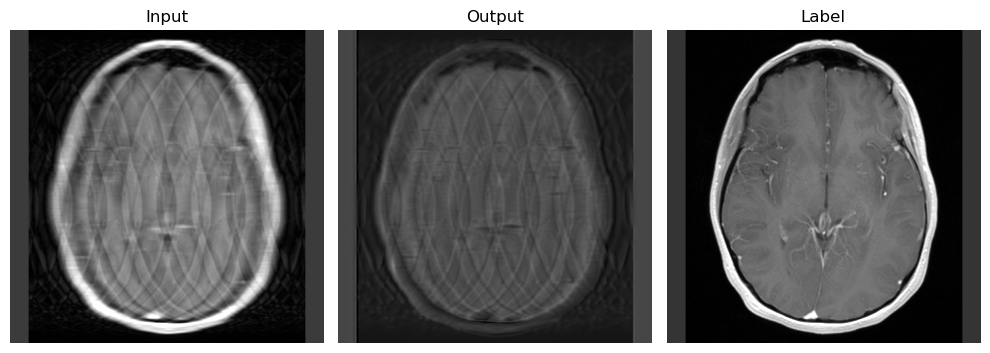

In [22]:
# plot input, output, label
input = img.squeeze().detach().cpu().numpy()
out = out.squeeze().detach().cpu().numpy()
label = label.squeeze().detach().cpu().numpy()

x1, x2, y1, y2 = 20, -20, 20, -20


print(f"input: {input.min(), input.max(), input.mean(), input.std()}")
print(f"out: {out.min(), out.max(), out.mean(), out.std()}")
print(f"label: {label.min(), label.max(), label.mean(), label.std()}")

vmin_input = np.percentile(input, 0.5)
vmax_input = np.percentile(input, 99.5)
vmin_out = np.percentile(label, 0.5)
vmax_out = np.percentile(label, 99.5)


plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
plt.imshow(input[x1:x2, y1:y2], cmap="gray", vmin=vmin_input, vmax=vmax_input)
plt.title("Input")
plt.axis("off")
plt.subplot(1, 3, 2)
plt.imshow(out[x1:x2, y1:y2], cmap="gray", vmin=vmin_out, vmax=vmax_out)
plt.title("Output")
plt.axis("off")
plt.subplot(1, 3, 3)
plt.imshow(label[x1:x2, y1:y2], cmap="gray", vmin=vmin_out, vmax=vmax_out)
plt.title("Label")
plt.axis("off")

plt.tight_layout()
plt.show()

In [23]:
label_exp_temp = label_exp.clone()

# Experiment: tweak steps and time scheduling
def make_t_schedule(steps, schedule="linear", device=None):
    if schedule == "linear":
        t_vals = torch.linspace(0.0, 1.0, steps + 1, device=device)
    elif schedule == "cosine":
        s = torch.linspace(0.0, 1.0, steps + 1, device=device)
        t_vals = 0.5 - 0.5 * torch.cos(torch.pi * s)
    elif schedule == "sigmoid":
        s = torch.linspace(-4.0, 4.0, steps + 1, device=device)
        t_vals = torch.sigmoid(s)
    else:
        raise ValueError(f"unknown schedule: {schedule}")
    return t_vals

def rectified_flow_sample_sched(model, img, text, instruction, steps=10, schedule="linear", t_eps=1e-4):
    t_vals = make_t_schedule(steps, schedule=schedule, device=img.device)
    z = torch.randn_like(img)
    for i in range(steps):
        t = t_vals[i].view(1, 1, 1, 1).expand(img.shape[0], 1, 1, 1)
        t_next = t_vals[i + 1].view(1, 1, 1, 1).expand(img.shape[0], 1, 1, 1)
        x_pred = model.forward(
            img=img,
            text=text,
            use_bottleneck=True,
            grad_encoder=True,
            instruction=instruction,
            flow_xt=z,
            flow_t=t.view(img.shape[0], 1),
        )
        denom = (1.0 - t).clamp_min(t_eps)
        v_pred = (x_pred - z) / denom
        z = z + (t_next - t) * v_pred
    return z

steps = 10
schedule = "linear"  # linear | cosine | sigmoid
t_eps = 1e-4

with torch.no_grad():
    out_exp = rectified_flow_sample_sched(model, img, text, instruction, steps=steps, schedule=schedule, t_eps=t_eps)

print("steps", steps, "schedule", schedule, "t_eps", t_eps)
print("out shape:", tuple(out_exp.shape))
print("out mse: ", torch.mean((out_exp.detach().cpu() - label_exp_temp.detach().cpu()) ** 2).item())

steps 10 schedule linear t_eps 0.0001
out shape: (1, 1, 512, 512)
out mse:  0.5993846654891968


In [24]:
# for steps in [10, 20, 40]:
#     for schedule in ["linear", "cosine", "sigmoid"]:
#         t_eps = 1e-4

#         with torch.no_grad():
#             out_exp = rectified_flow_sample_sched(model, img, text, instruction, steps=steps, schedule=schedule, t_eps=t_eps)
        
#         print("steps", steps, "schedule", schedule, "t_eps", t_eps)
#         print("out mse: ", torch.mean((out_exp.detach().cpu() - label_exp_temp.detach().cpu()) ** 2).item())